In [3]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from src.TopoExplanation import *

## Generate Synthetic Dataset with zero values being the decisive factor

In [5]:
n_samples = 500
n_dim = 5
perc_replace = 0.1
X = np.random.uniform(0.05,0.5,(n_samples,n_dim))
indices = np.arange(n_samples)

for col in range(X.shape[1]):
    to_replace = np.random.permutation(indices)[:int(indices.size * perc_replace)]
    X[to_replace,col] = 0
    
y = (X == 0).any(axis=1).astype(int) #if "0" appears in any column -> y = 1

pd.set_option("display.precision", 2)
df = pd.DataFrame(np.hstack((X,y.reshape(-1,1))))
df.columns = ['1','2','3','4','5','target']
df

,1,2,3,4,5,target
0,0.12,0.35,0.07,0.33,0.36,0.0
1,0.15,0.07,0.21,0.09,0.00,1.0
2,0.16,0.18,0.29,0.36,0.32,0.0
3,0.12,0.13,0.45,0.30,0.44,0.0
4,0.22,0.00,0.29,0.00,0.26,1.0
...,...,...,...,...,...,...
495,0.13,0.48,0.13,0.13,0.46,0.0
496,0.26,0.08,0.32,0.32,0.08,0.0
497,0.49,0.29,0.30,0.28,0.32,0.0
498,0.17,0.18,0.28,0.41,0.07,0.0


## Train a neural network model with two hidden layers

In [8]:
batch_size = 16
num_epochs = 100
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train).float()
X_test_tens = torch.tensor(X_test).float()

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train).view(-1, 1).float()
output_dim = 1

In [11]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.08197 | Acc: 97.429 | F1: 96.68755
Epoch 040: | Loss: 0.01417 | Acc: 99.714 | F1: 99.63370
Epoch 060: | Loss: 0.15732 | Acc: 94.190 | F1: 92.55797
Epoch 080: | Loss: 0.07084 | Acc: 98.286 | F1: 97.87063
Epoch 100: | Loss: 0.03797 | Acc: 99.143 | F1: 98.83450
Set to eval


In [12]:
X_test_df = pd.DataFrame(X_test)
X_test_tens = torch.tensor(X_test_df.to_numpy()).float()
y_test_df = pd.Series(y_test)
X_test_c, Y_test_c = get_correct_predictions(model,X_test_df,X_test_tens,y_test_df,averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (146, 5)
Y_test of correct predictions shape: (146,)
Label in Y_test of correct predictions ratio: 
 [[ 0 84]
 [ 1 62]]


## Use the sigmoid function as the prediction probability function for Mapper

[<matplotlib.lines.Line2D at 0x7fc2a8881cd0>]

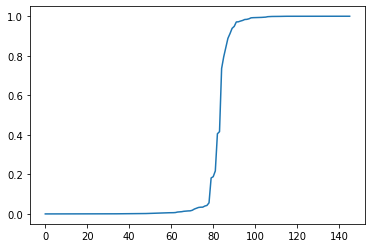

In [13]:
predictions = torch.sigmoid(model(X_test_c_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)

In [14]:
np.random.seed(rs)
torch.manual_seed(rs)

columns = np.arange(X.shape[1])
print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(pd.DataFrame(X,columns=columns))
uniform_baseline = bun.create_uniform_baseline(pd.DataFrame(X,columns=columns))
gaussian_baseline = bun.create_gaussian_baseline(pd.DataFrame(X,columns=columns), 0.5)
train_baseline = bun.create_train_baseline(pd.DataFrame(X,columns=columns))

Loading all baselines..


In [15]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
df_X = pd.DataFrame(X,columns=columns)
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_c_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,df_X.min(), df_X.max(), columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]

Start integrated gradients for correct predictions with black_baseline
--- '0.13' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '0.65' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '1.31' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '1.25' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '1.29' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.20' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.28' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '1.99' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '1.99' seconds computation time ---
Start DeepSHAP for correct predic

## Parameter Tuning for Mapper

### Step 1: Compute the Mapper outputs for different resolutions and gains

In [21]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
all_bootstrap_dist = []
function = predictions.reshape(-1,1)
for method in methods:
    for _exp in explanations[method]:
        exp =_exp.copy()
        exp[np.abs(exp)>0.01] = 1
        bootstrap_dist = []
        for r in reversed(resolutions):
            b = []
            for g in gains:
                params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
                  "resolutions": np.array([r]), "gains": np.array([g]), "inp": "point cloud", 
                  "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=1)}
                b.append(bootstrap_mapper(exp,params))
            bootstrap_dist.append(b) 
        all_bootstrap_dist.append(bootstrap_dist)

### Step 2: Visualize the 95% CI bootstrap distances and identify the minima
#### Note: Red rectangles are the parameter combination that we choose in the paper. This can be changed when the outputs from the explanations are different due to randomness.

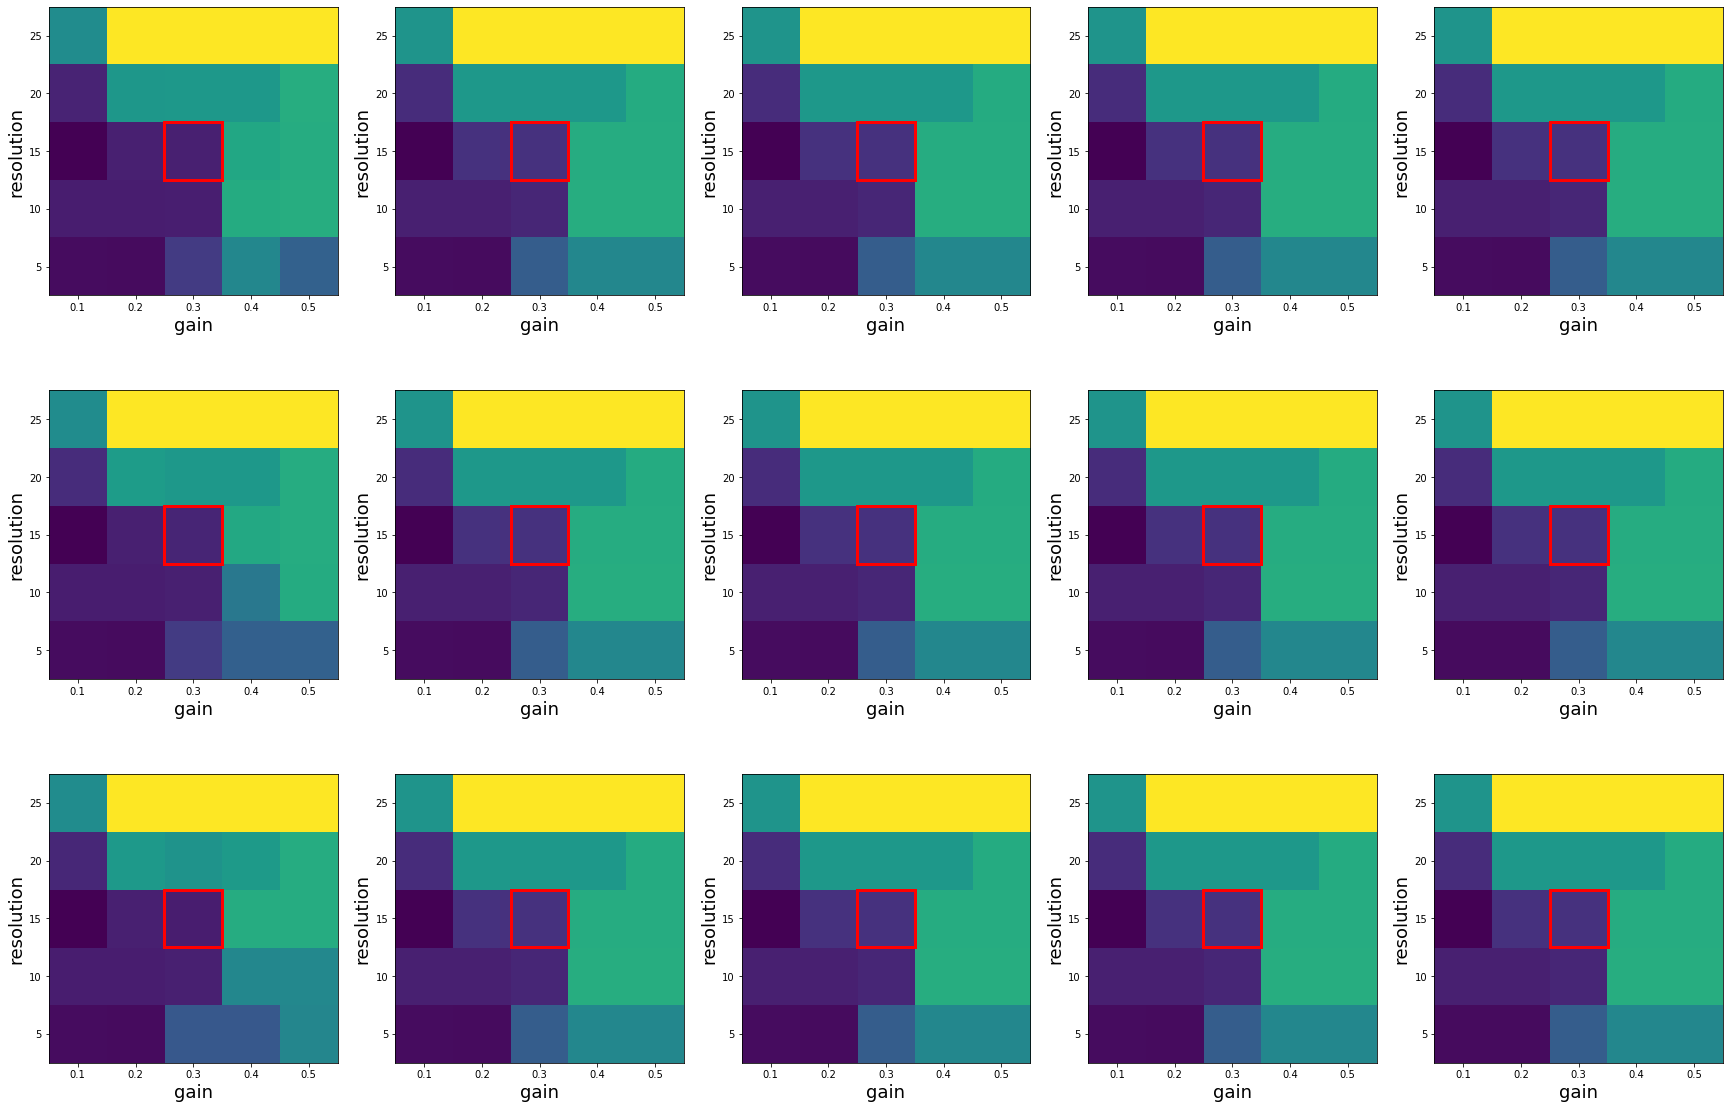

In [27]:
axes = plt.subplots(3, 5, figsize=(30,20))[1].reshape(-1)
vmin = np.min(all_bootstrap_dist)
vmax = np.max(all_bootstrap_dist)
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for b,ax in zip(all_bootstrap_dist,axes):
    ax.imshow(b,vmin=vmin,vmax=vmax)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(gains)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(resolutions)
    ax.set_ylim(-.5,4.5)
    ax.set_xlabel('gain', fontsize=18)
    ax.set_ylabel('resolution', fontsize=18)
    highlight_cell(2,2, ax=ax,color="red", linewidth=3)

Text(0.5, 1.0, '95% CI of bottleneck distances')

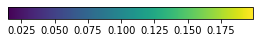

In [25]:
# axis of the colormap
a = np.array([[vmin,vmax]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal')
plt.title('95% CI of bottleneck distances')

## Generate the resulted Mapper Graphs

In [28]:
resolution = 15
gain = 0.3
all_mappers = []
function = predictions
params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
          "resolutions": np.array([resolution]), "gains": np.array([gain]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=1)}
for method in methods:
    i = 0
    for _exp in explanations[method]:
        exp =_exp.copy()
        exp[np.abs(exp)>0.01] = 1
        M = MapperComplex(**params).fit(exp)
        all_mappers.append(M)

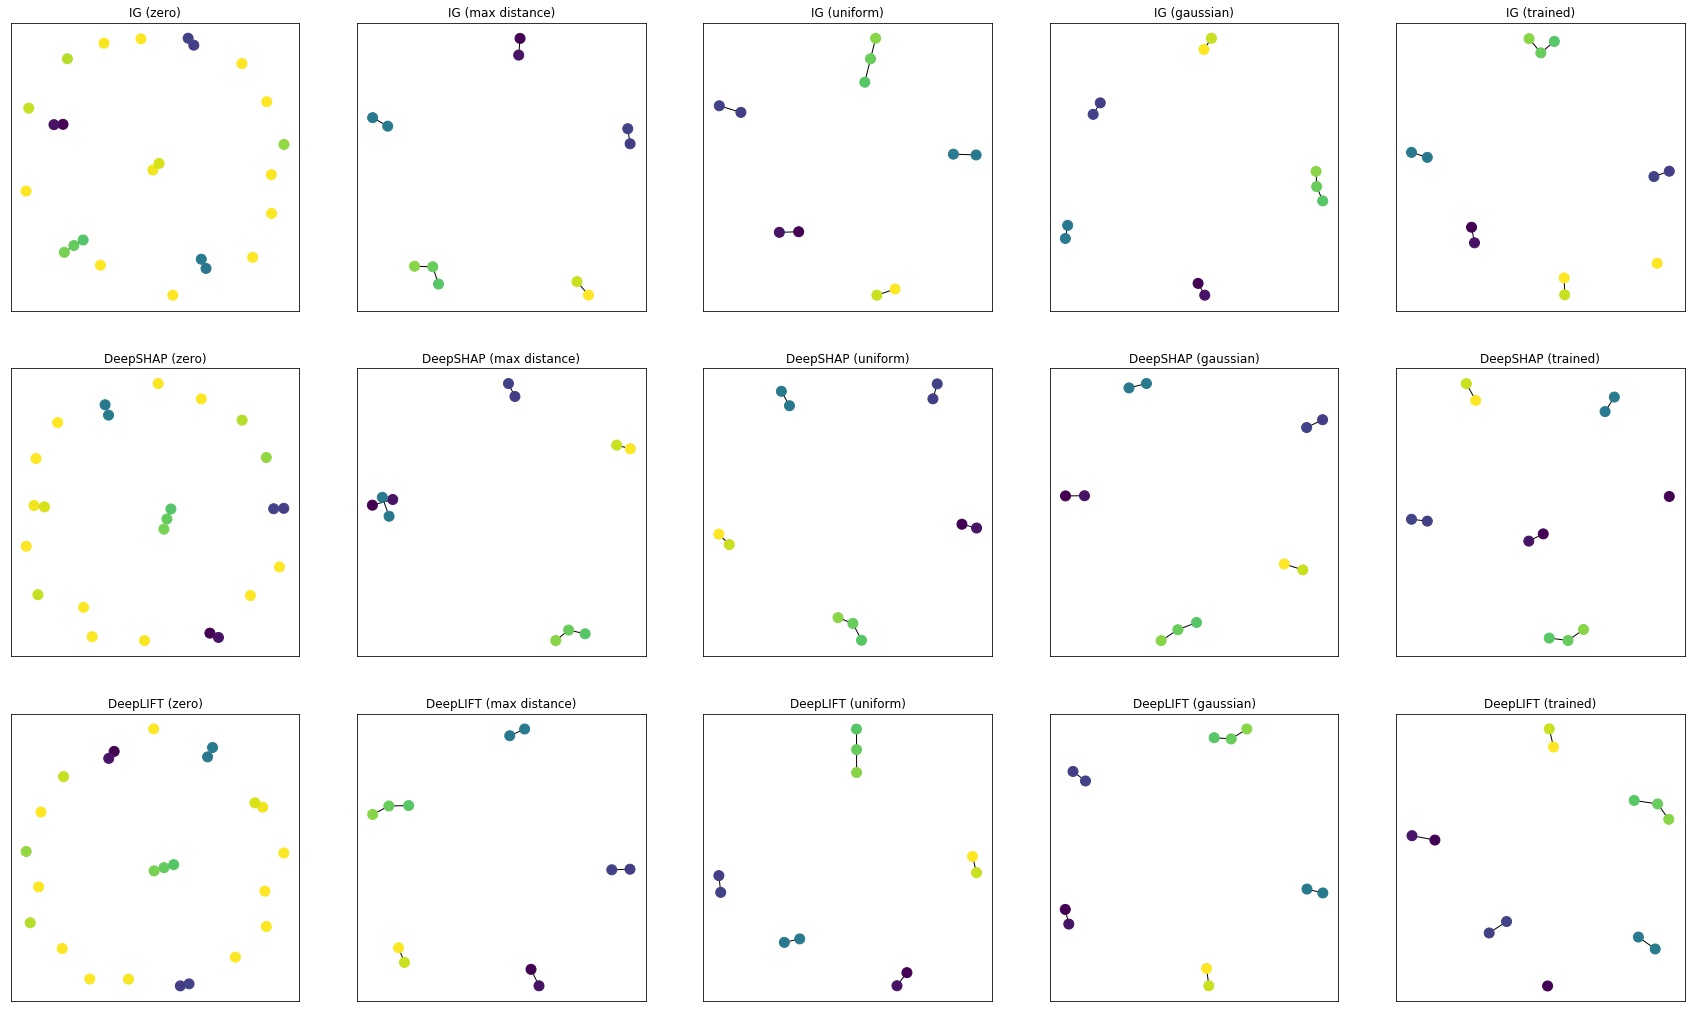

In [32]:
axes = plt.subplots(3, 5, figsize=(30,18))[1].reshape(-1)
all_mappers_flatten = []
vals = []
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']
names = [ '{} ({})'.format(m,b)  for m in methods for b in baselines]
for (M, ax, name) in zip(all_mappers, axes, names):
    G = mapper2networkx(M)
    nx.draw(G, pos=nx.spring_layout(G), 
            node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()], ax=ax,node_size=100)
    vals += [M.node_info_[node]["colors"][0] for node in G.nodes()]
    ax.axis('on')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(name)
plt.show()

## Compute the pairwise distances among the topological graphs with different methods and baselines.

In [35]:
all_dists = np.zeros((len(all_mappers),len(all_mappers)))
for i in range(len(all_mappers)):
    for j in range(i+1,len(all_mappers)):
        all_dists[i,j] = bottleneck_distance(all_mappers[i],all_mappers[j])
        all_dists[j,i] = all_dists[i,j]

Text(0.5, 1.0, 'bottleneck distance')

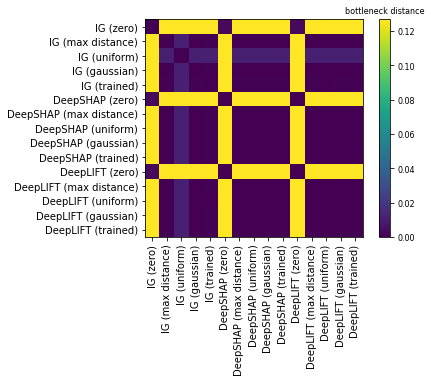

In [16]:
im=plt.imshow(all_dists)
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']
names = [ '{} ({})'.format(m,b)  for m in methods for b in baselines]
plt.xticks(np.arange(15),names,rotation=90)
plt.yticks(np.arange(15),names,rotation=0)
plt.ylim(14.5,-.5)
clb=plt.colorbar(im)
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('bottleneck distance',fontsize=8)

## Plotting the row wise sum of pairwise distance matrices to reveal the comparisons

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

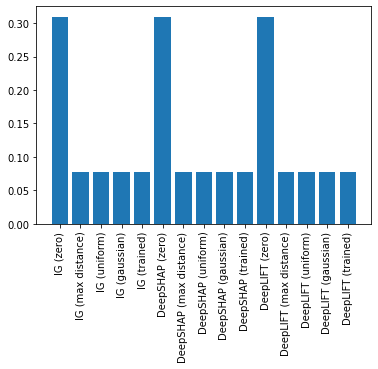

In [36]:
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']
names = [ '{} ({})'.format(m,b)  for m in methods for b in baselines]
plt.bar(names,np.sum(all_dists,0))
plt.xticks(rotation='vertical')